In [38]:
%%python -m pip install pandas nltk textblob gensim matplotlib seaborn wordcloud pillow scikit-learn
%%python -m textblob.download_corpora

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

from gensim import corpora
from gensim.models import LdaModel

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

In [40]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("vader_lexicon")

sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
# https://huggingface.co/datasets/Amod/mental_health_counseling_conversations
dataset = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)

In [42]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3512 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [43]:
dataset.describe()

,Context,Response
count,3512,3512
unique,995,2480
top,I have so many issues to address. I have a his...,
freq,94,4


In [44]:
dataset.head(10)

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...
5,I'm going through some things with my feelings...,"Heck, sure thing, hun!Feelings of 'depression'..."
6,I'm going through some things with my feelings...,You are exhibiting some specific traits of a p...
7,I'm going through some things with my feelings...,That is intense. Depression is a liar. Sometim...
8,I'm going through some things with my feelings...,It sounds like you may be putting yourself las...
9,I'm going through some things with my feelings...,It must be really difficult to experience what...


In [45]:
dataset.tail(10)

,Context,Response
3502,I am in my early 20s and I still live with my ...,Hi! I'm sorry you are having such a tough ti...
3503,My daughter seemed to be developing at a norma...,Hello.It sounds like you are really concerned ...
3504,"After first meeting the client, what is the pr...",Hi. This is an excellent question ! I think...
3505,I start counseling/therapy in a few days (I'm ...,Hi there ! As someone who has practiced as a ...
3506,My ex-wife married and used me to have a child...,The thing that confuses a child the most is fo...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit..."
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...
3511,I just took a job that requires me to travel f...,hmm this is a tough one!


In [46]:
stopWords = set(stopwords.words('english'))

def preprocessText(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopWords]
    return ' '.join(words)

In [47]:
dataset['contextClean'] = dataset['Context'].apply(preprocessText)
dataset['responseClean'] = dataset['Response'].apply(preprocessText)

In [48]:
dataset[['contextClean', 'responseClean']].head(10)

,contextClean,responseClean
0,im going things feelings barely sleep nothing ...,everyone thinks youre worthless maybe need fin...
1,im going things feelings barely sleep nothing ...,hello thank question seeking advice feelings w...
2,im going things feelings barely sleep nothing ...,first thing id suggest getting sleep need impa...
3,im going things feelings barely sleep nothing ...,therapy essential feeling depressed worthless ...
4,im going things feelings barely sleep nothing ...,first want let know alone feelings always some...
5,im going things feelings barely sleep nothing ...,heck sure thing hunfeelings depression deeplyr...
6,im going things feelings barely sleep nothing ...,exhibiting specific traits particular temperam...
7,im going things feelings barely sleep nothing ...,intense depression liar sometimes depression p...
8,im going things feelings barely sleep nothing ...,sounds like may putting last wrote want fix is...
9,im going things feelings barely sleep nothing ...,must really difficult experience going right t...


In [49]:
dataset[['contextClean', 'responseClean']].tail(10)

,contextClean,responseClean
3502,early still live parents cant afford live alon...,hi im sorry tough time situation worked number...
3503,daughter seemed developing normal rate age sta...,helloit sounds like really concerned daughter ...
3504,first meeting client process counselor facilit...,hi excellent question think answer probably va...
3505,start counselingtherapy days im freaking main ...,hi someone practiced clinical psychologist yea...
3506,exwife married used child uses child pawn know...,thing confuses child parent come go life child...
3507,grandsons stepmother sends school pink barbie ...,absolutely never childs best interest use humi...
3508,boyfriend recovery drug addiction recently got...,im sorry tension bfa relationship means two pe...
3509,birth mother attempted suicide several times p...,true answer one really say certaintythe variab...
3510,think adult life making depressed often sleep ...,help believe require offers youwhat get relati...
3511,took job requires travel far away home family ...,hmm tough one


In [50]:
sia = SentimentIntensityAnalyzer()

def getSentimentScores(text):
    return sia.polarity_scores(text)

In [51]:
dataset['contextSentiment'] = dataset['contextClean'].apply(getSentimentScores)
dataset['responseSentiment'] = dataset['responseClean'].apply(getSentimentScores)

In [52]:
dataset[['contextSentiment', 'responseSentiment']].head(10)

,contextSentiment,responseSentiment
0,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.147, 'neu': 0.642, 'pos': 0.211, 'co..."
1,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.143, 'neu': 0.625, 'pos': 0.232, 'co..."
2,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou..."
3,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.231, 'neu': 0.553, 'pos': 0.216, 'co..."
4,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.067, 'neu': 0.8, 'pos': 0.133, 'comp..."
5,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.097, 'neu': 0.548, 'pos': 0.355, 'co..."
6,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.0, 'neu': 0.575, 'pos': 0.425, 'comp..."
7,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.282, 'neu': 0.511, 'pos': 0.207, 'co..."
8,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.199, 'neu': 0.594, 'pos': 0.207, 'co..."
9,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.136, 'neu': 0.516, 'pos': 0.348, 'co..."


In [53]:
dataset[['contextSentiment', 'responseSentiment']].tail(10)

,contextSentiment,responseSentiment
3502,"{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp...","{'neg': 0.059, 'neu': 0.64, 'pos': 0.301, 'com..."
3503,"{'neg': 0.0, 'neu': 0.888, 'pos': 0.112, 'comp...","{'neg': 0.149, 'neu': 0.61, 'pos': 0.241, 'com..."
3504,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.087, 'neu': 0.572, 'pos': 0.341, 'co..."
3505,"{'neg': 0.739, 'neu': 0.261, 'pos': 0.0, 'comp...","{'neg': 0.305, 'neu': 0.521, 'pos': 0.174, 'co..."
3506,"{'neg': 0.156, 'neu': 0.844, 'pos': 0.0, 'comp...","{'neg': 0.107, 'neu': 0.73, 'pos': 0.162, 'com..."
3507,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...","{'neg': 0.301, 'neu': 0.531, 'pos': 0.169, 'co..."
3508,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'comp...","{'neg': 0.161, 'neu': 0.77, 'pos': 0.068, 'com..."
3509,"{'neg': 0.283, 'neu': 0.657, 'pos': 0.06, 'com...","{'neg': 0.052, 'neu': 0.58, 'pos': 0.368, 'com..."
3510,"{'neg': 0.377, 'neu': 0.519, 'pos': 0.104, 'co...","{'neg': 0.0, 'neu': 0.593, 'pos': 0.407, 'comp..."
3511,"{'neg': 0.382, 'neu': 0.618, 'pos': 0.0, 'comp...","{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp..."


In [54]:
dataset['contextNeg'] = dataset['contextSentiment'].apply(lambda x: x['neg'])
dataset['responsePos'] = dataset['responseSentiment'].apply(lambda x: x['pos'])

In [55]:
dataset[['contextNeg', 'responsePos']].head(10)

,contextNeg,responsePos
0,0.0,0.211
1,0.0,0.232
2,0.0,0.320
3,0.0,0.216
4,0.0,0.133
5,0.0,0.355
6,0.0,0.425
7,0.0,0.207
8,0.0,0.207
9,0.0,0.348


In [56]:
dataset[['contextNeg', 'responsePos']].head(10)

,contextNeg,responsePos
0,0.0,0.211
1,0.0,0.232
2,0.0,0.320
3,0.0,0.216
4,0.0,0.133
5,0.0,0.355
6,0.0,0.425
7,0.0,0.207
8,0.0,0.207
9,0.0,0.348


In [57]:
dataset['contextTokens'] = dataset['contextClean'].apply(word_tokenize)

dictionary = corpora.Dictionary(dataset['contextTokens'])
corpus = [dictionary.doc2bow(text) for text in dataset["contextTokens"]]


ldaModel = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
for idx, topic in ldaModel.print_topics(-1):
    print(f'Topic {idx + 1}: {topic}')

Topic 1: 0.025*"im" + 0.023*"still" + 0.018*"get" + 0.016*"ive" + 0.014*"like" + 0.012*"feeling" + 0.011*"therapy" + 0.009*"never" + 0.009*"normal" + 0.009*"couple"
Topic 2: 0.029*"im" + 0.015*"dont" + 0.015*"know" + 0.014*"feel" + 0.012*"really" + 0.012*"people" + 0.012*"like" + 0.011*"get" + 0.010*"even" + 0.010*"time"
Topic 3: 0.024*"im" + 0.024*"years" + 0.020*"issues" + 0.020*"ive" + 0.018*"counseling" + 0.017*"many" + 0.015*"history" + 0.015*"address" + 0.013*"depression" + 0.013*"sexual"
Topic 4: 0.024*"im" + 0.023*"feel" + 0.021*"dont" + 0.018*"like" + 0.014*"want" + 0.011*"know" + 0.010*"love" + 0.008*"really" + 0.008*"relationship" + 0.007*"get"
Topic 5: 0.016*"know" + 0.014*"im" + 0.014*"want" + 0.011*"dont" + 0.010*"always" + 0.010*"feel" + 0.009*"relationship" + 0.009*"afraid" + 0.009*"like" + 0.009*"makes"


In [58]:
dataset['responseLength'] = dataset['responseClean'].apply(lambda x: len(x.split()))

avgResponseLength = dataset['responseLength'].mean()
print(f'Average Response Length: {avgResponseLength}')

responseSentiments = dataset['responseSentiment'].apply(lambda x: x['compound'])
print('Response Sentiment Distribution:')
responseSentiments.describe()

Average Response Length: 84.35506833712984
Response Sentiment Distribution:


,responseSentiment
count,3512.000000
mean,0.540052
std,0.632233
min,-0.998700
25%,0.357425
50%,0.876000
75%,0.966525
max,0.999400


In [59]:
dataset['contextCompound'] = dataset['contextSentiment'].apply(lambda x: x['compound'])
dataset['responseCompound'] = dataset['responseSentiment'].apply(lambda x: x['compound'])

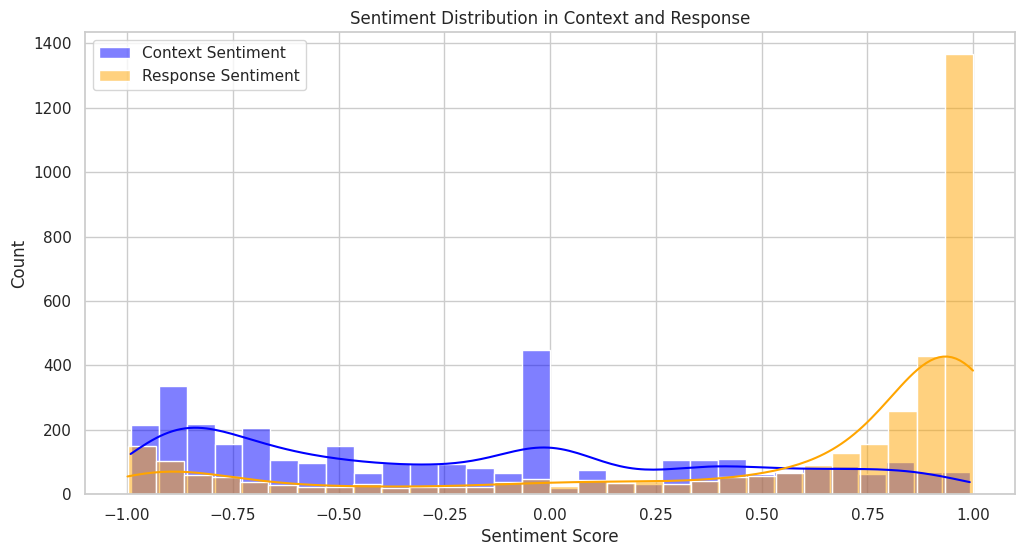

In [60]:
plt.figure(figsize=(12, 6))
sns.histplot(dataset['contextCompound'], color='blue', kde=True, label='Context Sentiment', bins=30)
sns.histplot(dataset['responseCompound'], color='orange', kde=True, label='Response Sentiment', bins=30)
plt.xlabel('Sentiment Score')
plt.title('Sentiment Distribution in Context and Response')
plt.legend()
plt.show()

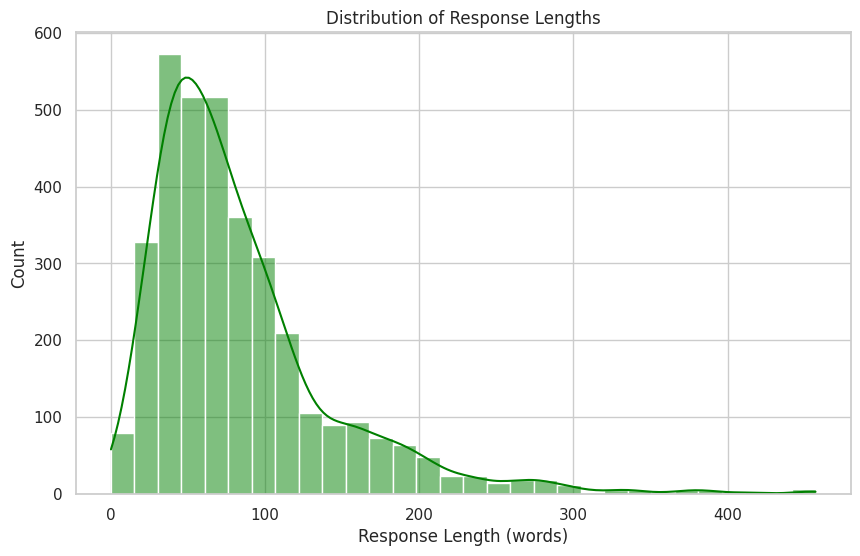

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['responseLength'], bins=30, kde=True, color='green')
plt.xlabel('Response Length (words)')
plt.title('Distribution of Response Lengths')
plt.show()

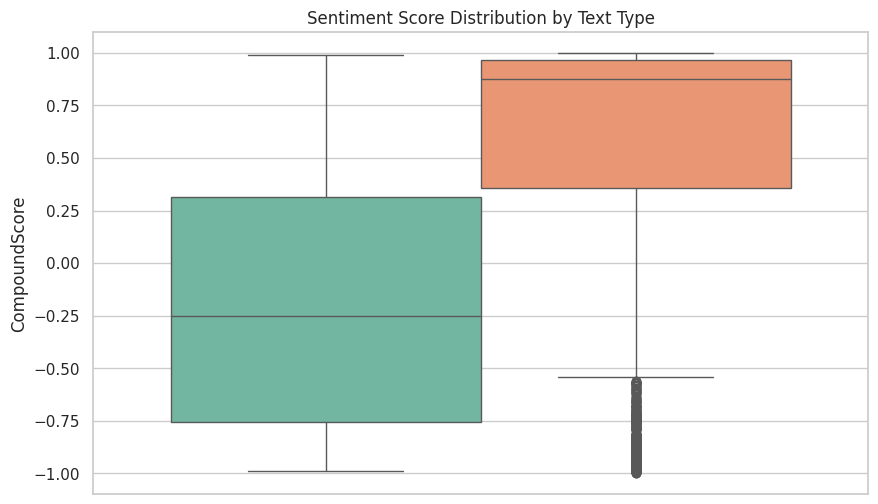

In [62]:
sentimentData = dataset[['contextCompound', 'responseCompound']].melt(var_name='TextType', value_name='CompoundScore')

plt.figure(figsize=(10, 6))
sns.boxplot(hue='TextType', y='CompoundScore', data=sentimentData, palette='Set2', legend=False)
plt.title('Sentiment Score Distribution by Text Type')
plt.show()

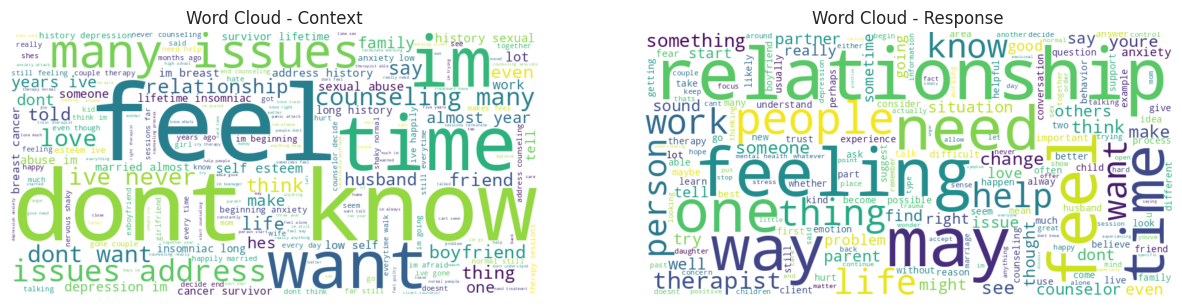

In [63]:
contextWords = ' '.join(dataset['contextClean'].tolist())
responseWords = ' '.join(dataset['responseClean'].tolist())

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

contextWordCloud = WordCloud(width=800, height=400, background_color='white').generate(contextWords)
axes[0].imshow(contextWordCloud, interpolation='bilinear')
axes[0].set_title('Word Cloud - Context')
axes[0].axis('off')

responseWordCloud = WordCloud(width=800, height=400, background_color='white').generate(responseWords)
axes[1].imshow(responseWordCloud, interpolation='bilinear')
axes[1].set_title('Word Cloud - Response')
axes[1].axis('off')

plt.show()

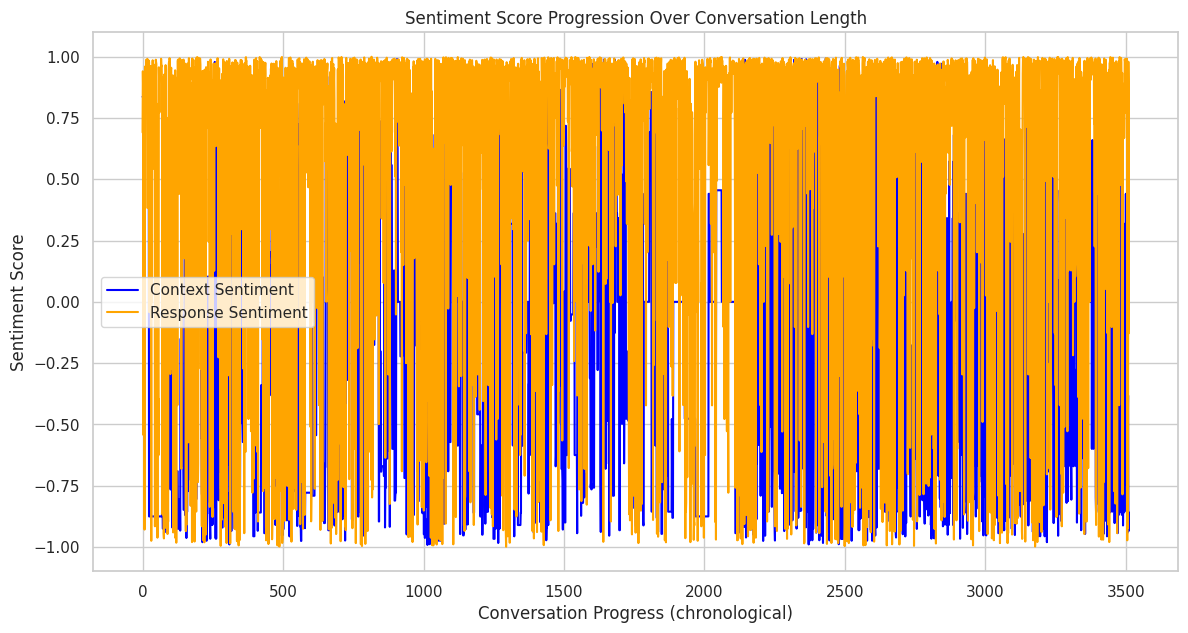

In [64]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=dataset, x=dataset.index, y='contextCompound', label='Context Sentiment', color='blue')
sns.lineplot(data=dataset, x=dataset.index, y='responseCompound', label='Response Sentiment', color='orange')
plt.xlabel('Conversation Progress (chronological)')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Progression Over Conversation Length')
plt.legend()
plt.show()

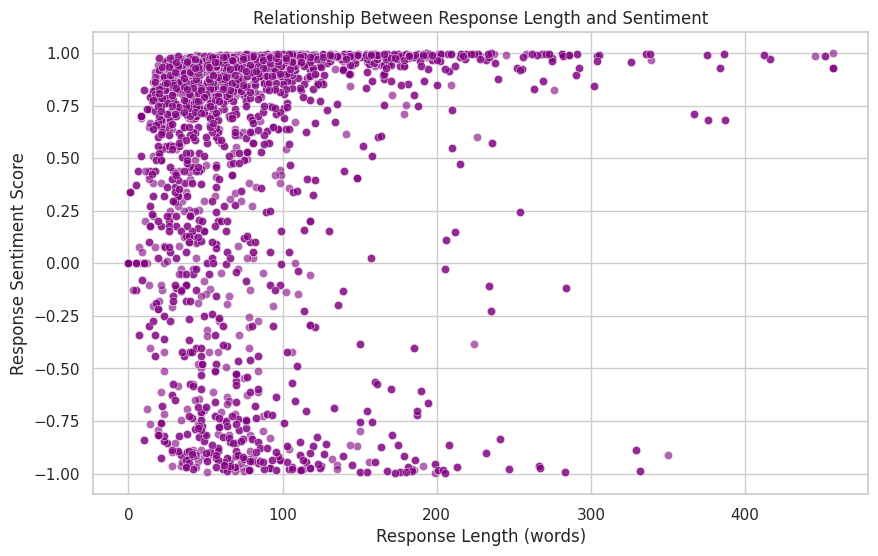

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='responseLength', y='responseCompound', alpha=0.6, color='purple')
plt.xlabel('Response Length (words)')
plt.ylabel('Response Sentiment Score')
plt.title('Relationship Between Response Length and Sentiment')
plt.show()

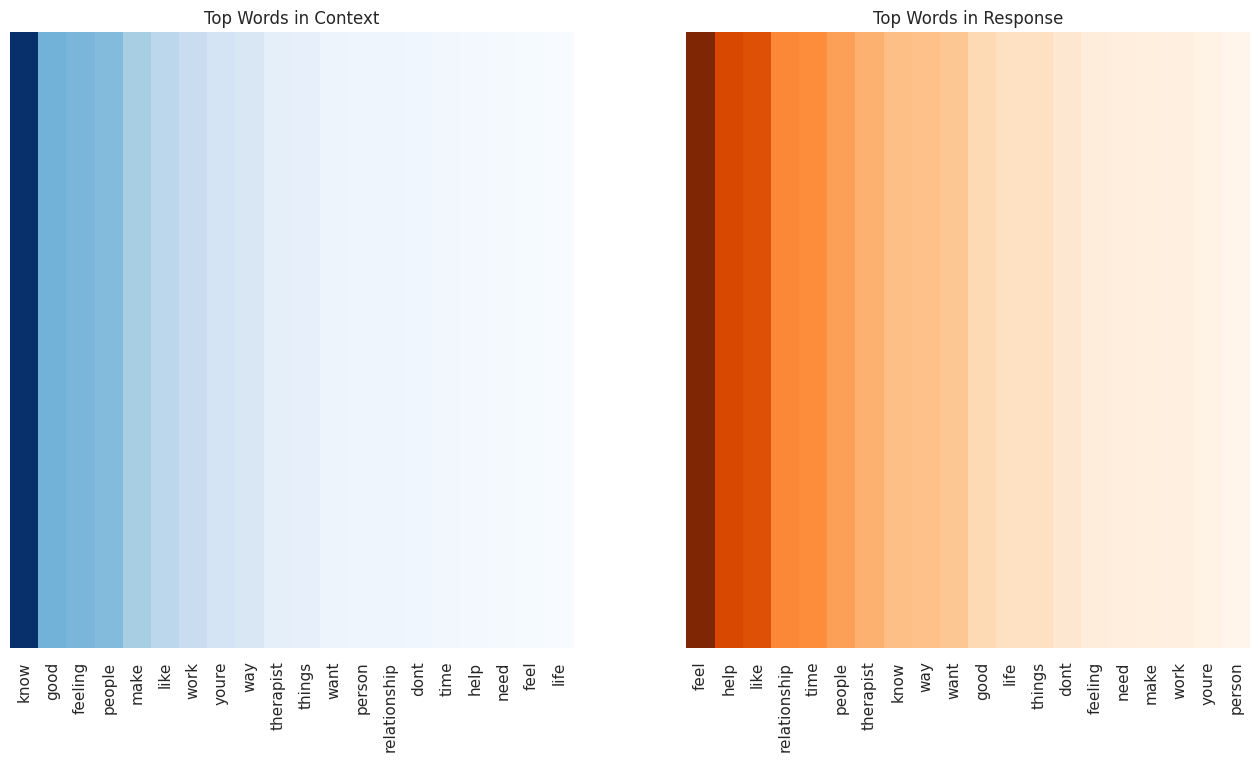

In [66]:
vectorizer = CountVectorizer(max_features=20, stop_words='english')
contextMatrix = vectorizer.fit_transform(dataset['contextClean'])
responseMatrix = vectorizer.fit_transform(dataset['responseClean'])

contextDf = pd.DataFrame(contextMatrix.toarray(), columns=vectorizer.get_feature_names_out())
responseDf = pd.DataFrame(responseMatrix.toarray(), columns=vectorizer.get_feature_names_out())

contextWordCounts = contextDf.sum().sort_values(ascending=False)
responseWordCounts = responseDf.sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(contextWordCounts.values.reshape(1, -1), cmap='Blues', cbar=False, ax=axes[0], xticklabels=contextWordCounts.index, yticklabels=[])
axes[0].set_title('Top Words in Context')

sns.heatmap(responseWordCounts.values.reshape(1, -1), cmap='Oranges', cbar=False, ax=axes[1], xticklabels=responseWordCounts.index, yticklabels=[])
axes[1].set_title('Top Words in Response')

plt.show()